In [1]:
import jax
import tqdm
import numpy as np 
from jax import lax 
import networkx as nx
from jax import random
from jax import make_jaxpr
from jax import device_put
from jax import numpy as jnp
import matplotlib.pyplot as plt
from jax import grad, jit, vmap, pmap 


In [2]:
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['axes.labelsize'] = 14
plt.style.use('seaborn-whitegrid')

In [3]:
def whereis(x):
    # print the device of x
    print(x.device_buffer.device())


In [4]:
seed = 2
nn = 68
dt = 0.01
ns = 10_000
nt = 25000

key = random.PRNGKey(seed)
SC = jax.random.normal(key, (nn, nn), dtype=np.float32)
x = jax.random.normal(key, (nn, ns), dtype=np.float32)
y = jax.random.normal(key, (nn, ns), dtype=np.float32)
eta = jax.random.normal(key, (nn, ns), dtype=np.float32) + 1.01

tau = 3.0
rtau = 1.0 / tau

xs = []

def f(x, y, SC, eta, tau):
    
    rtau = 1.0 / tau
    gx = jax.numpy.matmul(SC, x)
    dx = tau * (x - x*x*x/3 +y)
    dy = rtau * (eta - x + 1e-2 * gx)
    return x + dt * dx, y + dt * dy

f_jit = jit(f) # jit the function 4x faster

for t in tqdm.trange(nt):
    x, y = f_jit(x, y, SC, eta, tau)
    if t % 100 == 0:
        xs.append(x)

100%|██████████| 25000/25000 [00:33<00:00, 744.00it/s] 


In [4]:
def Kuramoto(x, t, coupling, omega, adj):

    x_i, x_j = jax.numpy.meshgrid(x, x)
    interactions = jax.numpy.matmul(adj, jnp.sin(x_j - x_i))  # Aij * sin(j-i)
    dxdt = omega + coupling * interactions.sum(axis=0)  # sum over incoming interactions
    return dxdt

def order_parameter(theta):
    # calculate the order parameter
    N = theta.shape[1]
    r = np.zeros(len(theta))
    for i in range(len(theta)):
        r[i] = abs(sum(np.exp(1j * theta[i,:]))) / N
    return r

In [5]:
# K = np.arange(0.0, 0.4, 0.01)   # coupling
N = 3                           # number of nodes
K = 1.0
dt = 0.01                       # time step
T = 200.0                       # simulation time
T_trans = 100.0                 # transition time
omega_0 = np.random.normal(0, 0.1, N)  # natural frequencies
adj = nx.to_numpy_array(nx.complete_graph(N))  # adjacency matrix
x = np.random.uniform(0, 2*np.pi, N)  # initial conditions

x = device_put(x)
adj = device_put(adj)
omega = device_put(omega_0)

Kuramoto_gpu = jit(Kuramoto, backend='gpu')

xs = []
for t in tqdm.trange(int(T/dt)):
    x = x + Kuramoto_gpu(x, t, K, omega, adj) * dt
    xs.append(x)
xs = np.array(xs)
r = order_parameter(xs)




100%|██████████| 20000/20000 [00:10<00:00, 1835.55it/s]


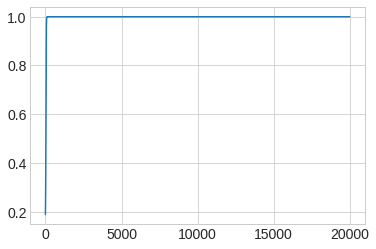

In [6]:
plt.plot(r)